# Bayesian AB Testing - Part IV - Choosing a Prior

### Series Structure
This post is the 4th part of a series of blog posts on applying Bayesian AB Testing methods to real life product scenarios. It uses some of the concepts discussed in the [1st](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec) and [2nd](https://towardsdatascience.com/bayesian-ab-testing-part-ii-revenue-1fbcf04f96cd) parts of the series.

1. [Modelling and analysis of conversion based test metrics (rate metrics)](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec)
2. [Modelling and analysis of revenue based test metrics (continuous metrics)](https://towardsdatascience.com/bayesian-ab-testing-part-ii-revenue-1fbcf04f96cd)
3. [Calculating test duration](https://towardsdatascience.com/bayesian-ab-testing-part-iii-test-duration-f2305215009c)
4. Choosing an appropriate prior
5. Running tests with multiple variants

### What is a prior distribution?

In Bayesian Inference a prior distribution is a probability distribution used to indicate our beliefs about an unknown variable prior to drawing samples from the underlying population. We then use this data to update our beliefs about the variable using [Bayes' Rule](https://en.wikipedia.org/wiki/Bayes%27_theorem), resulting in a posterior distribution for the variable.

Within the [context of an AB test](https://towardsdatascience.com/bayesian-experimentation-methods-for-products-636514951e43), the prior distribution is a set of values we believe the test metric to take with a probability assigned to each value. We then draw samples in the form of a randomised experiment which we use to calculate our posterior distributions. These posterior distributions are, in turn, used to calculate the results of the AB test.

### How does the choice of prior distribution affect the experiment?

Well, Bayes rule tells us the following

$p(\theta | data) = \frac{p(\theta) * p(data | \theta)}{p(data)}$ 

which, in words can be written as

$posterior = \frac{prior * likelihood}{evidence}$

where the denominator is a normalising constant. So the rule can be simplified to

$posterior \propto prior * likelihood$

Since the results of the test are calculated on the posterior, the choice of prior has an impact on the test, but we need to be careful just how much of an impact it has. If we choose too strong a prior, the prior will be the dominant factor and the likelihood of drawing the samples wouldn't make much of an effect, rendering the experiment useless. It would result in both posteriors, control and variant, converging quickly and in the test being inconclusive. However, if we choose a very weak prior the posterior will be predominantly dependent on the likelihood, so we'd need more samples to reach a conclusive result, resulting in a longer test and slower progression of our product.

In order to make our posterior distributions easier, we can also use [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior). A conjugate prior is a prior distribution we can use with the likelihood function such that the posterior distribution we calculate is of a similar form to the prior distribution. Using conjugate priors simplifies our calculations while still providing a good statistical model for the test metric. We've seen how the simplified calculations and choice of conjugate priors have worked in our favour in the [first](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec) and [second](https://towardsdatascience.com/bayesian-ab-testing-part-ii-revenue-1fbcf04f96cd) posts of this series. 

### Types of priors

Before we dive into how to go about choosing a prior, let's take a quick look into the three three main types of priors.
- Subjective 
    - Based on the experimenter's knowledge of the field
    - In our case this would be based on the product and data team's prior experience with this test metric
- Objective and Informative 
    - Based on historical data of the value
    - In our case this would be based on any historical data we have about our test metric
    - It could also be a posterior distribution from a previous experiment
- Non-informative
    - Priors which don't convey any information about the value
    - In our case this would be a uniform distribution over the test metric space

Let us assume that we're new to the company and product so we don't have sufficient information to use a subjective prior. We also don't want to use a non-informative prior because we believe it will result in a longer test and thus hinder the progression of our product. Let's look at a couple of techniques we can use to choose an objective and informative prior.

### Inspection

The simplest method to choose a prior distribution is by plotting and inspecting historical data of the relevant test metric. In order to understand this further, let us consider the experiment from the [1st post of this series](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec). Let’s assume we’ve recently changed the messaging on an upsell screen and want to AB test it before releasing to our wider user base. We hypothesise that the changes we’ve made will result in a significantly better conversion rate. 

Before we set up the test, we want to use historical data to choose a prior. Let's have a look at how we can plot the data to help us choose. We're going to split the data into 100 partitions, work out the conversion rate for each one and plot the conversion rates as a histogram.

Text(0.5, 1.0, 'Histogram of Prior Conversion Rates')

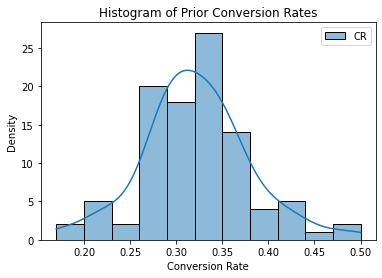

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
    
prior_data = pd.read_csv('prior_data_conversions.csv')

x = np.linspace(0,1,1000)

partitions = np.array_split(prior_data, 100)

rates = []

for partition in partitions:
    rates.append(partition['converted'].mean())

_, ax = plt.subplots()

sns.histplot(rates, kde=True, label='CR')
ax.legend()
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Density')
ax.set_title('Histogram of Prior Conversion Rates')

We can now choose a prior distribution that is similar to the distribution above, but a bit weaker. We don't want to choose too strong a prior since we want the likelihood to be the dominant factor for calculating the prior. We do, however, want to choose a strong enough prior such that the test duration will be shorter.

We'll be using the beta distribution to model our conversion rate since it’s a flexible distribution over $[0,1]$ and is also a good conjugate prior. So let's go ahead and plot some potential priors of varying strength for our exercise.

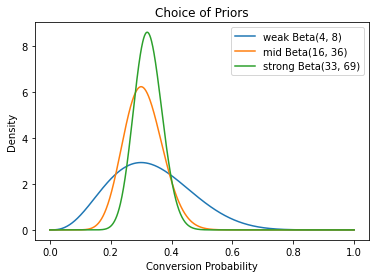

In [31]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1)

x = np.linspace(0,1,1000)

beta_weak = beta(4, 8)
beta_mid = beta(16, 36)
beta_strong = beta(33, 69)

ax.plot(x, beta_weak.pdf(x), label=f'weak Beta({4}, {8})')
ax.plot(x, beta_mid.pdf(x), label=f'mid Beta({16}, {36})')
ax.plot(x, beta_strong.pdf(x), label=f'strong Beta({33}, {69})')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Choice of Priors')
ax.legend()

We see that even the strongest prior that we've plotted is weaker than the historical distribution of the conversion rate. So we can ahead and choose $Beta(33, 69)$ as our prior distribution. 

We can now run our experiment, calculate posteriors and results of the test. To find out more about how to do this, in particular for the outlined experiment, check out [this](https://towardsdatascience.com/bayesian-ab-testing-part-i-conversions-ac2635f878ec) post. 

### Monte Carlo Markov Chain (MCMC)

A more complicated but very interesting method for choosing a prior distribution is using Monte Carlo Markov Chains. This method is particularly useful for models where our unknown variable is determined by other random variables, each of which have their own distribution. So it's a good technique to use for AB tests where the test metric is [revenue based](https://towardsdatascience.com/bayesian-ab-testing-part-ii-revenue-1fbcf04f96cd) (like avergage revenue per user).

Before we jump into how to use this method, let me introduce how it works - MCMC deserves a post of its own, so this introduction will be very brief. MCMC methods allow us to sample from an unknown distribution by running simulations (hence the [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) part of the name) in which we create a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) which has our unknown distribution as it's [stationary distribution](https://en.wikipedia.org/wiki/Stationary_distribution).

But what do these terms actually mean? Well, a *Markov Chain* is a process which jumps between a set of states, and each jump follows the [Markov Property](https://en.wikipedia.org/wiki/Markov_property). Put simply, this means that the probability of jumping to a particular state is only dependent on the current state of the process and not the previous states which the process has jumped from. Due to the memoryless property, and the notion of jumping between different states, this process is often referred to as a random walk. Let us assume we perform this random walk for an infinite number of steps, then the *stationary distribution* is the proportion of steps in which we visited each state.

Now that we have a bit of background on MCMC methods, let's get stuck into using them to choose a prior for our AB test. Let us consider the experiment from [the 2nd post of this series](https://towardsdatascience.com/bayesian-ab-testing-part-ii-revenue-1fbcf04f96cd). We've recently made UX changes to a store feature in our app. We believe these changes make it easier for our users to make bigger in-app purchases and we want to AB test this before releasing to our wider user base. We hypothesise that the changes we've made will result in a significantly higher Average Revenue per User.

We model the Revenue generated by each user as a random variable $R = X*Y$, where:
- $X$ is a Bernoulli random variable which refers to whether the user made a purchase, with conversion probability $\lambda$
    - $X \sim Ber(\lambda)$
- $Y$ is an Exponential random variable which refers to the size of the purchase if it is made, with rate parameter $\theta$
    - $Y \sim Exp(\theta)$

We can use conjugate priors for $\lambda$ and $\theta$ to make our calculations easier.

$\lambda \sim Beta(\alpha, \beta)$

$\theta \sim Gamma(k, \Theta)$

We now need to choose priors for our parameters, which can be non-informative.

$\alpha \sim Uniform(0, 100)$

$\beta \sim Uniform(0, 100)$

$k \sim Uniform(0, 5)$

$\Theta \sim Uniform(0, 5)$

We can now go ahead and use MCMC methods to choose sensible values for our parameters. We're going to be using the [pyMC](https://docs.pymc.io/) package. Let's instantiate the model, add our stochastic variables and pass in our observed values of historical data.


In [3]:
import arviz as az
import pymc3 as pm

prior_revenue = pd.read_csv('prior_data_revenue.csv')

rev_observed = prior_revenue[prior_revenue['converted'] == 1]['revenue'].values
conv_observed = prior_revenue['converted'].values

model = pm.Model()

with model:
    alpha = pm.Uniform("alpha", lower=0, upper=100)
    beta = pm.Uniform("beta", lower=0, upper=100)
    k = pm.Uniform("k", lower=0, upper=5)
    theta = pm.Uniform("theta", lower=0, upper=5)

    cr = pm.Beta('cr', alpha=alpha, beta=beta)
    rr = pm.Gamma('rr', alpha=k, beta=(1/theta))

    conversion = pm.Bernoulli('conversion', p=cr, observed=conv_observed)
    revenue_per_sale = pm.Exponential('revenue_per_sale', lam=rr, observed=rev_observed)

    trace = pm.sample(10000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rr, cr, theta, k, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.


Once we've fit the model, we can now plot the distribution of each parameter, and print out some summary stats.

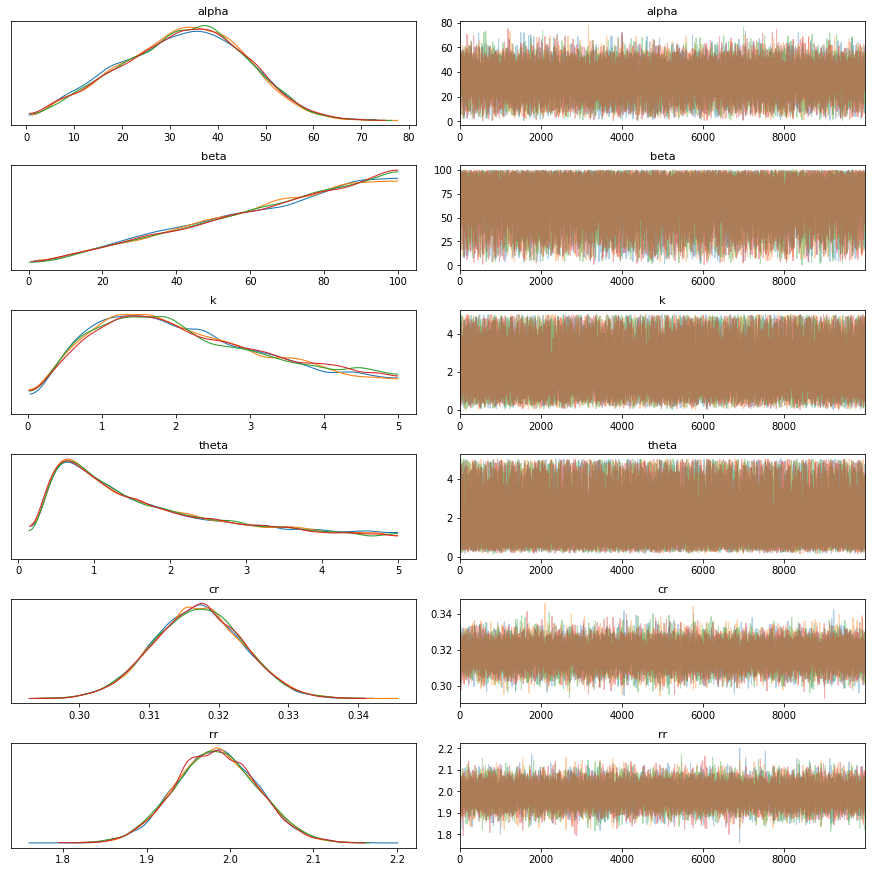

In [14]:
with model:
    az.plot_trace(trace, compact=False)

In [15]:
with model:
    display(az.summary(trace, kind='stats', round_to=2))

mean     sd  hdi_3%  hdi_97%
alpha  32.52  12.88    8.05    55.45
beta   66.91  23.53   24.61   100.00
k       2.27   1.25    0.29     4.62
theta   1.96   1.30    0.24     4.44
cr      0.32   0.01    0.30     0.33
rr      1.98   0.05    1.89     2.08

In [5]:
map_estimate = pm.find_MAP(model=model)

print(map_estimate)


{'alpha_interval__': array(-0.12533657), 'beta_interval__': array(8.80625901), 'k_interval__': array(27.29672141), 'theta_interval__': array(-2.45181315), 'cr_logodds__': array(-0.76846922), 'rr_log__': array(0.68420429), 'alpha': array(46.87068127), 'beta': array(99.98502299), 'k': array(5.), 'theta': array(0.39653029), 'cr': array(0.31681034), 'rr': array(1.98219395)}


The two main stats we're going to use are the mean of each parameter and the [MAP](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) estimate of each parameter. Put simply, the latter is an estimate of the points of each parameter's distribution which result in the modes of the conversion and revenue rate distributions. Since our parameter priors are uniform, these estimates are also the [MLEs](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).[x](https://towardsdatascience.com/mle-vs-map-a989f423ae5c)

Let's go ahead and plot priors using each of these stats.

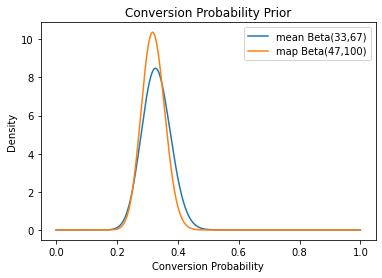

In [36]:
from scipy.stats import beta

cr_prior_mean = beta(33, 67)
cr_prior_map = beta(47, 100)

x = np.linspace(0,1,1000)

_, ax = plt.subplots()

sns.lineplot(x=x, y=cr_prior_mcmc.pdf(x), label='mean Beta(33,67)')
sns.lineplot(x=x, y=cr_prior_map.pdf(x), label='map Beta(47,100)')
ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Conversion Probability Prior')
ax.legend()

In the case of the conversion probability $\lambda$, both the distributions are pretty similar. We'll go ahead and choose the weaker one for good measure so our prior is given by

$\lambda \sim Beta(33,67)$

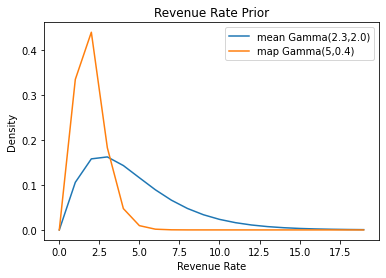

In [37]:
from scipy.stats import gamma

rr_prior_mean = gamma(a=2.3, scale=2.0)
rr_prior_map = gamma(a=5, scale=0.4)

x = list(range(20))

rr_mcmc = [rr_prior_mcmc.pdf(i) for i in x]
rr_map = [rr_prior_map.pdf(i) for i in x]

_, ax = plt.subplots()

sns.lineplot(x=x, y=rr_mcmc, label='mean Gamma(2.3,2.0)')
sns.lineplot(x=x, y=rr_map, label='map Gamma(5,0.4)')

ax.set_xlabel('Revenue Rate')
ax.set_ylabel('Density')
ax.set_title('Revenue Rate Prior')
ax.legend()

Similarly, in the case of the rate of revenue \theta, let's go ahead and choose the weaker prior which uses the mean of the $k$ and $\Theta$ distributions from our MCMC algorithm. So we have

$\theta \sim Gamma(2.3, 2.0)$

Now that we have our priors, we can run our experiment, calculate posteriors and results of the test. To find out more about how to do this, in particular for the outlined experiment, check out [this](https://towardsdatascience.com/bayesian-ab-testing-part-ii-revenue-1fbcf04f96cd) post.